In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
base = pd.read_csv('petr4_treinamento.csv')

In [ ]:
base = base.dropna()

In [ ]:
base.iloc[:,1:2]

,Open
0,19.990000
1,19.809999
2,20.330000
3,20.480000
4,20.110001
...,...
1240,15.750000
1241,15.750000
1242,15.990000
1243,16.100000


In [ ]:
base_treinamento = base.iloc[:,1:2].values

In [ ]:
#muitas camadas então é preciso normalizam (0-1)
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

#Estrutura da base de dados para a previsão temporal

In [ ]:
previsores = []
preco_real = []
for i in range(90, 1242):
  previsores.append(base_treinamento_normalizada[i-90:i, 0])
  preco_real.append(base_treinamento_normalizada[i,0])
previsores, preco_real = np.array(previsores), np.array(preco_real)

Formato do input_shape : (batch_size, timesteps, input_dim)

In [ ]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1],1))

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape=(previsores.shape[1],1))) #units: numero de celulas de memoria (deve ser grande)
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation ='linear')) #regressão

regressor.compile(optimizer = 'rmsprop', loss= 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs = 100, batch_size=32)

Epoch 1/100
36/36 [==============================] - 18s 246ms/step - loss: 0.0304 - mean_absolute_error: 0.1264
Epoch 2/100
36/36 [==============================] - 7s 182ms/step - loss: 0.0158 - mean_absolute_error: 0.0976
Epoch 3/100
36/36 [==============================] - 8s 210ms/step - loss: 0.0124 - mean_absolute_error: 0.0858
Epoch 4/100
36/36 [==============================] - 7s 185ms/step - loss: 0.0118 - mean_absolute_error: 0.0846
Epoch 5/100
36/36 [==============================] - 7s 203ms/step - loss: 0.0109 - mean_absolute_error: 0.0817
Epoch 6/100
36/36 [==============================] - 7s 205ms/step - loss: 0.0090 - mean_absolute_error: 0.0738
Epoch 7/100
36/36 [==============================] - 7s 179ms/step - loss: 0.0079 - mean_absolute_error: 0.0683
Epoch 8/100
36/36 [==============================] - 8s 210ms/step - loss: 0.0081 - mean_absolute_error: 0.0703
Epoch 9/100
36/36 [==============================] - 6s 179ms/step - loss: 0.0084 - mean_absolute_error

In [ ]:
base_teste = pd.read_csv('/content/petr4_teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)

In [ ]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values #pegando apenas os dados que estao relacionados com o periodo que queremos prever

In [ ]:
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

In [ ]:
X_teste = []
for i in range(90, 112):
  X_teste.append(entradas[i-90:i, 0])
X_teste=np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = regressor.predict(X_teste)

1/1 [==============================] - 2s 2s/step


In [ ]:
previsoes= normalizador.inverse_transform(previsoes)

In [ ]:
previsoes.mean(), preco_real_teste.mean()

(17.358469, 17.87454563636364)

#Gráficos

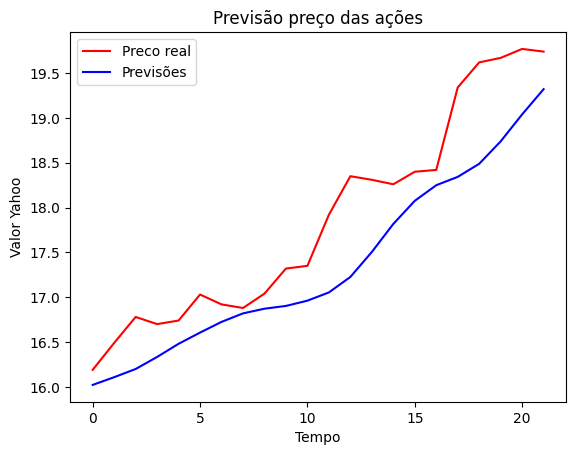

In [ ]:
plt.plot(preco_real_teste, color='red', label = 'Preco real')
plt.plot(previsoes, color='blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()